# Домашнее задание №6. Нейросети в обработке текста

In [18]:
#предобработка
from string import punctuation
#from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
import nltk

nltk.download('wordnet')
nltk.download("punkt")
nltk.download('stopwords')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\leva_\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\leva_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leva_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\leva_\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Задание

1. Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [19]:
max_words = 2000
max_len = 20
num_classes = 1

# обучение
epochs = 10
batch_size = 512
print_batch_n = 100

In [20]:
# пути к данным
dataset_train  = 'data/train.csv'
dataset_test  = 'data/test.csv'

In [21]:
#загрузка данных
data_train = pd.read_csv(dataset_train, encoding='utf-8')
data_test = pd.read_csv(dataset_test, encoding='utf-8')

In [22]:
#тренировочный датасет
data_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [23]:
#тестовый датасет
data_test.head()

,id,text
0,204150,Тектоника и рельеф-самое ужасное в мире мучение(
1,204151,"Ходили запускать шар желаний, но у нас не полу..."
2,204152,"Хочу лето только ради того, что бы направить н..."
3,204153,RT @RonyLiss: @colf_ne блин((\nа я шипперила Ф...
4,204154,"RT @anna_romt: @ZADROT_PO_IGRAM блин,каждое во..."


In [24]:
#разделение тренировочного датасета на обучающий и валидационный
df_train, df_valid = train_test_split(data_train, test_size=0.3, random_state=42)

In [25]:
#датасет для обучения модели
df_train.head()

,id,text,class
152276,152276,"Вот капец. @xam_vz вышел, а я его ещё ни разу ...",0
3026,3026,"проснулась пораньше, чтобы хоть немного подгот...",1
129883,129883,Мамка сегодня спонтанна купила мне киндер сюрп...,1
103260,103260,"@iKurash1 Неприятно будет, если выяснится, что...",0
1592,1592,"RT @IRkIN163rus: Почему нам нравятся люди, кот...",0


In [26]:
df_train['class'].value_counts()

1    64260
0    62766
Name: class, dtype: int64

In [27]:
#датасет для валидации модели
df_valid.head()

,id,text,class
133370,133370,@ArtMayers Я думала туса интересная))) а то на...,1
84601,84601,"рядом дышии, и не будем мы грустить заяя...\nп...",1
78178,78178,вот че она ржет надо мной=( http://t.co/dGP8la...,0
49055,49055,А мы и сообщения не пишем:( #жизньболь http://...,0
159239,159239,@Horan_69_ID иди полежи или таблетку выпей(,0


In [28]:
df_valid['class'].value_counts()

1    27803
0    26638
Name: class, dtype: int64

### 1. Предобработка данных <a id='section_1'></a>

In [29]:
#множество стоп-слов
sw = set(stopwords.words('english'))
print(sw)

{"aren't", 'hasn', "hasn't", 'through', 'only', 'me', 'aren', 'is', "couldn't", 'has', 'again', 'themselves', "you'll", 'mightn', 'haven', 'in', 'such', 'off', 'her', 'that', 'any', 'have', 'our', "didn't", 'between', 'nor', 'hadn', 'after', 'couldn', 'yours', 'shan', 'needn', 'shouldn', 'own', "it's", 'being', 'so', "hadn't", 'yourselves', 'him', 're', 'of', 'where', "isn't", 'at', 'other', 'she', 'few', 'should', 'o', 'had', 'but', 'below', 'up', "mustn't", 'above', 'than', 'during', 'by', 'or', 'now', 'did', 'don', "shouldn't", 'into', 'having', 'hers', 'most', "haven't", "don't", 'same', 'these', 'no', 'you', 'the', "should've", 'mustn', "you'd", 'their', 'until', 'won', 'whom', 'about', 'will', 'we', 'a', 'when', 'each', 'weren', 'himself', 'if', 'some', 'isn', 'them', 'll', 'wouldn', 'am', 'more', 'y', "that'll", 'too', 'doesn', 'be', 'he', 'been', 'were', "you've", 'are', 'ain', 'didn', 'who', 'how', "mightn't", "needn't", 'all', 'was', 'not', 'once', 'very', 'because', 'then', 

In [30]:
#пунктуация
exclude = set(punctuation)
print(exclude)

{'@', '^', '%', '+', '{', '-', ')', '*', '}', '[', '>', '(', '.', '"', ':', '~', '_', '&', '$', ']', '=', '|', "'", ',', '!', '#', '`', '?', '\\', '/', '<', ';'}


In [31]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\leva_\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [32]:
#морфологический анализ для английского текста
lemmatizer = WordNetLemmatizer()

#пример работы
lemmatizer.lemmatize('dogs'), lemmatizer.lemmatize('says')

('dog', 'say')

In [33]:
#функция преобразования текста
def preprocess_text(txt):
    #преобразуем входные данные в строку
    txt = str(txt)
    #удяляем знаки пунктуации
    txt = "".join(c for c in txt if c not in exclude)
    #приводим все к нижнему регистру
    txt = txt.lower()
    #лематизация
    txt = [lemmatizer.lemmatize(w) for w in txt.split() if w not in sw]
    return " ".join(txt)

In [34]:
#преобразование текста в данных
from tqdm import tqdm 
tqdm.pandas()

df_train['text'] = df_train['text'].progress_apply(preprocess_text)
df_valid['text'] = df_valid['text'].progress_apply(preprocess_text)
data_test['text'] = data_test['text'].progress_apply(preprocess_text)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22684/22684 [00:00<00:00, 25804.00it/s]


In [35]:
#соединение всех обучающих данных в одну строку и приведение к нижнему регистру
train_corpus = " ".join(df_train["text"])
train_corpus = train_corpus.lower()

In [36]:
#токенезация (разбиваем строку на слова)
tokens = word_tokenize(train_corpus)
tokens[:10]

['вот', 'капец', 'xamvz', 'вышел', 'а', 'я', 'его', 'ещё', 'ни', 'разу']

In [37]:
#отфильтруем токены (проверяем, чтобы все символы были или буквы или цифры)
tokens_filtered = [word for word in tokens if word.isalnum()]
print(tokens_filtered)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [38]:
#соберем max_words наиболее частых токенов

#частотное распределение: как часто встречается каждый токен в tokens_filtered
dist = FreqDist(tokens_filtered)
dist

FreqDist({'не': 41179, 'я': 34610, 'и': 32737, 'в': 31376, 'rt': 21279, 'на': 20976, 'а': 17280, 'что': 16734, 'с': 16069, 'у': 12112, ...})

In [39]:
#берем max_words наиболее часто встречающихся токенов
#(создаем упорядоченные пары (слово, частота) в количестве max_words штук и берем первые элементы пар)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # -1 - padding
len(tokens_filtered_top), tokens_filtered_top[:10]

(1999, ['не', 'я', 'и', 'в', 'rt', 'на', 'а', 'что', 'с', 'у'])

In [40]:
#словарь слово : индекс из tokens_filtered_top
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top)).items()}
vocabulary

{'не': 0,
 'я': 1,
 'и': 2,
 'в': 3,
 'rt': 4,
 'на': 5,
 'а': 6,
 'что': 7,
 'с': 8,
 'у': 9,
 'меня': 10,
 'как': 11,
 'мне': 12,
 'это': 13,
 'так': 14,
 'все': 15,
 'ты': 16,
 'но': 17,
 'по': 18,
 'ну': 19,
 'то': 20,
 'уже': 21,
 'за': 22,
 'же': 23,
 'вот': 24,
 'только': 25,
 'сегодня': 26,
 'да': 27,
 'еще': 28,
 'бы': 29,
 'нет': 30,
 'очень': 31,
 'тебя': 32,
 'хочу': 33,
 'к': 34,
 'когда': 35,
 'день': 36,
 'он': 37,
 'просто': 38,
 'мы': 39,
 'будет': 40,
 'от': 41,
 'было': 42,
 'тебе': 43,
 'из': 44,
 'теперь': 45,
 'даже': 46,
 'надо': 47,
 'тоже': 48,
 'если': 49,
 'завтра': 50,
 'о': 51,
 'до': 52,
 'там': 53,
 'его': 54,
 'есть': 55,
 'вообще': 56,
 'для': 57,
 'сейчас': 58,
 'нас': 59,
 'всё': 60,
 'она': 61,
 'могу': 62,
 'буду': 63,
 'кто': 64,
 'спасибо': 65,
 'люблю': 66,
 'почему': 67,
 'тут': 68,
 'вы': 69,
 'блин': 70,
 'без': 71,
 'они': 72,
 'или': 73,
 'знаю': 74,
 'раз': 75,
 'со': 76,
 '3': 77,
 'мой': 78,
 'больше': 79,
 'про': 80,
 'ничего': 81,
 'все

In [41]:
#преобразование текста в последовательность
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())  #токенизация
    tokens_filtered = [word for word in tokens if word.isalnum()] #фильтруем (только буквы и цифры)
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word]) #если слово в топе токенов, то добавляем его индекс в результат

    padding = [0] * (maxlen-len(result)) #нули дополняющие до maxlen
    return result[-maxlen:] + padding

In [42]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["text"]])
x_valid = np.asarray([text_to_sequence(text, max_len) for text in df_valid["text"]])
x_test = np.asarray([text_to_sequence(text, max_len) for text in data_test["text"]])

x_train.shape, x_valid.shape, x_test.shape

((127026, 20), (54441, 20), (22684, 20))

In [43]:
#данные после подготовки к обучению
torch.from_numpy(x_train[0])

tensor([  24,  400, 1151,    6,    1,   54,   93,  101,  976,    0,  420,  109,
          32,  690,    0,    0,    0,    0,    0,    0], dtype=torch.int32)

### 2. Построение и обучение модели<a id='section_2'></a>

In [44]:
#Датасет
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long() #преобразуем в целочисленный тензор
        self.target = torch.from_numpy(target).long() #преобразуем в целочисленный тензор
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]  #индексация данных
        y = self.target[index]  #индексация целевой переменной
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [45]:
#создание представителей классов Dataset и Dataloader
train_dataset = DataWrapper(x_train, df_train['class'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = DataWrapper(x_valid, df_valid['class'].values)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True)

In [46]:
for x, l in train_loader:
    print(x.shape, x[0])
    print(l.shape, l[0])
    break

torch.Size([512, 20]) tensor([226,  17,  39,  60,  23,  99,  36,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0])
torch.Size([512]) tensor(1)


In [47]:
#сверточная нейронная сеть
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = torch.sigmoid(output)
        return output

In [48]:
#инициализация модели
model = Net(vocab_size=max_words)
print(model)

Net(
  (embedding): Embedding(2000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)


In [49]:
#компиляция модели
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [50]:
#обучение модели
model.train()
th = 0.5

train_loss_history = []
valid_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]
        
        # обучение
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
       
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
        # выводим статистику о процессе обучения
        if i % 150 == 0:    # печатаем каждые 150 batches
            model.eval()
            
            print(f'Epoch [{epoch + 1}/{epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {loss:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0
            train_loss_history.append(loss)

            # выводим статистику на тестовых данных
            test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
            for j, data in enumerate(valid_loader):
                test_labels = data[1]
                test_outputs = model(data[0])
                
                # подсчет ошибки на тесте
                test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
                # подсчет метрики на тесте
                test_running_total += len(data[1])
                pred_test_labels = torch.squeeze((test_outputs > th).int())
                test_running_right += (test_labels == pred_test_labels).sum()
            
            valid_loss_history.append(test_loss.item())
            print(f'Val loss: {test_loss:.3f}. Val acc: {test_running_right / test_running_total:.3f}')
        
        model.train()
        
print('Training is finished!')

Epoch [1/10]. Step [1/249]. Loss: 0.692. Acc: 0.516. Val loss: 0.743. Val acc: 0.509
Epoch [1/10]. Step [151/249]. Loss: 0.644. Acc: 0.615. Val loss: 0.855. Val acc: 0.656
Epoch [2/10]. Step [1/249]. Loss: 0.558. Acc: 0.699. Val loss: 0.607. Val acc: 0.675
Epoch [2/10]. Step [151/249]. Loss: 0.589. Acc: 0.700. Val loss: 0.644. Val acc: 0.690
Epoch [3/10]. Step [1/249]. Loss: 0.519. Acc: 0.740. Val loss: 0.403. Val acc: 0.693
Epoch [3/10]. Step [151/249]. Loss: 0.510. Acc: 0.728. Val loss: 2.219. Val acc: 0.697
Epoch [4/10]. Step [1/249]. Loss: 0.454. Acc: 0.785. Val loss: 0.300. Val acc: 0.693
Epoch [4/10]. Step [151/249]. Loss: 0.501. Acc: 0.746. Val loss: 1.563. Val acc: 0.698
Epoch [5/10]. Step [1/249]. Loss: 0.458. Acc: 0.793. Val loss: 0.375. Val acc: 0.703
Epoch [5/10]. Step [151/249]. Loss: 0.491. Acc: 0.763. Val loss: 4.006. Val acc: 0.698
Epoch [6/10]. Step [1/249]. Loss: 0.466. Acc: 0.773. Val loss: 0.221. Val acc: 0.676
Epoch [6/10]. Step [151/249]. Loss: 0.474. Acc: 0.776. 

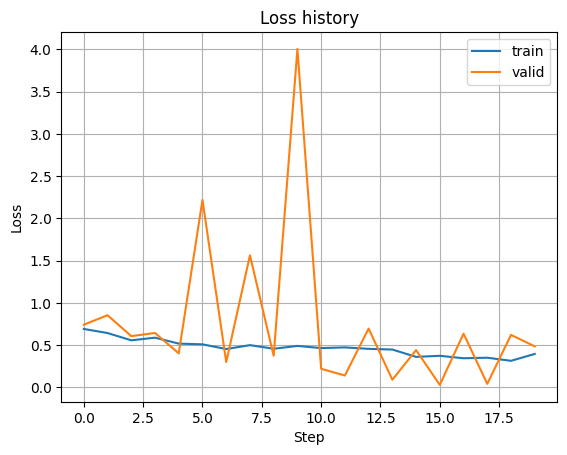

In [51]:
#визуализации функции потерь
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Step')
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()

### 3. Выводы<a id='section_3'></a>

In [52]:
#тестирование модели
input = torch.from_numpy(x_test).long()
test_outputs = model(input)
outputs_label = np.where(test_outputs > 0.5, 1, 0)
test_outputs, outputs_label

(tensor([[0.2012],
         [0.9452],
         [0.0617],
         ...,
         [0.7585],
         [0.0355],
         [0.3249]], grad_fn=<SigmoidBackward0>),
 array([[0],
        [1],
        [0],
        ...,
        [1],
        [0],
        [0]]))

1. Метрика на валидации растет немонотонно. Поэтому увеличение числа эпох не приводит к улучшению метрики на валидации.

2. Снижение скорости обучения способствует улучшению метрики.

3. Добавление Dropout не приводит к улучшению метрики.